In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import pynumdiff
import warnings
from astropy.constants import G
import astropy.units as u
from colossus.cosmology import cosmology
import symlib
import pynumdiff.kalman_smooth
import pynumdiff.optimize.kalman_smooth


/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_43955/3620300469.py:160: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


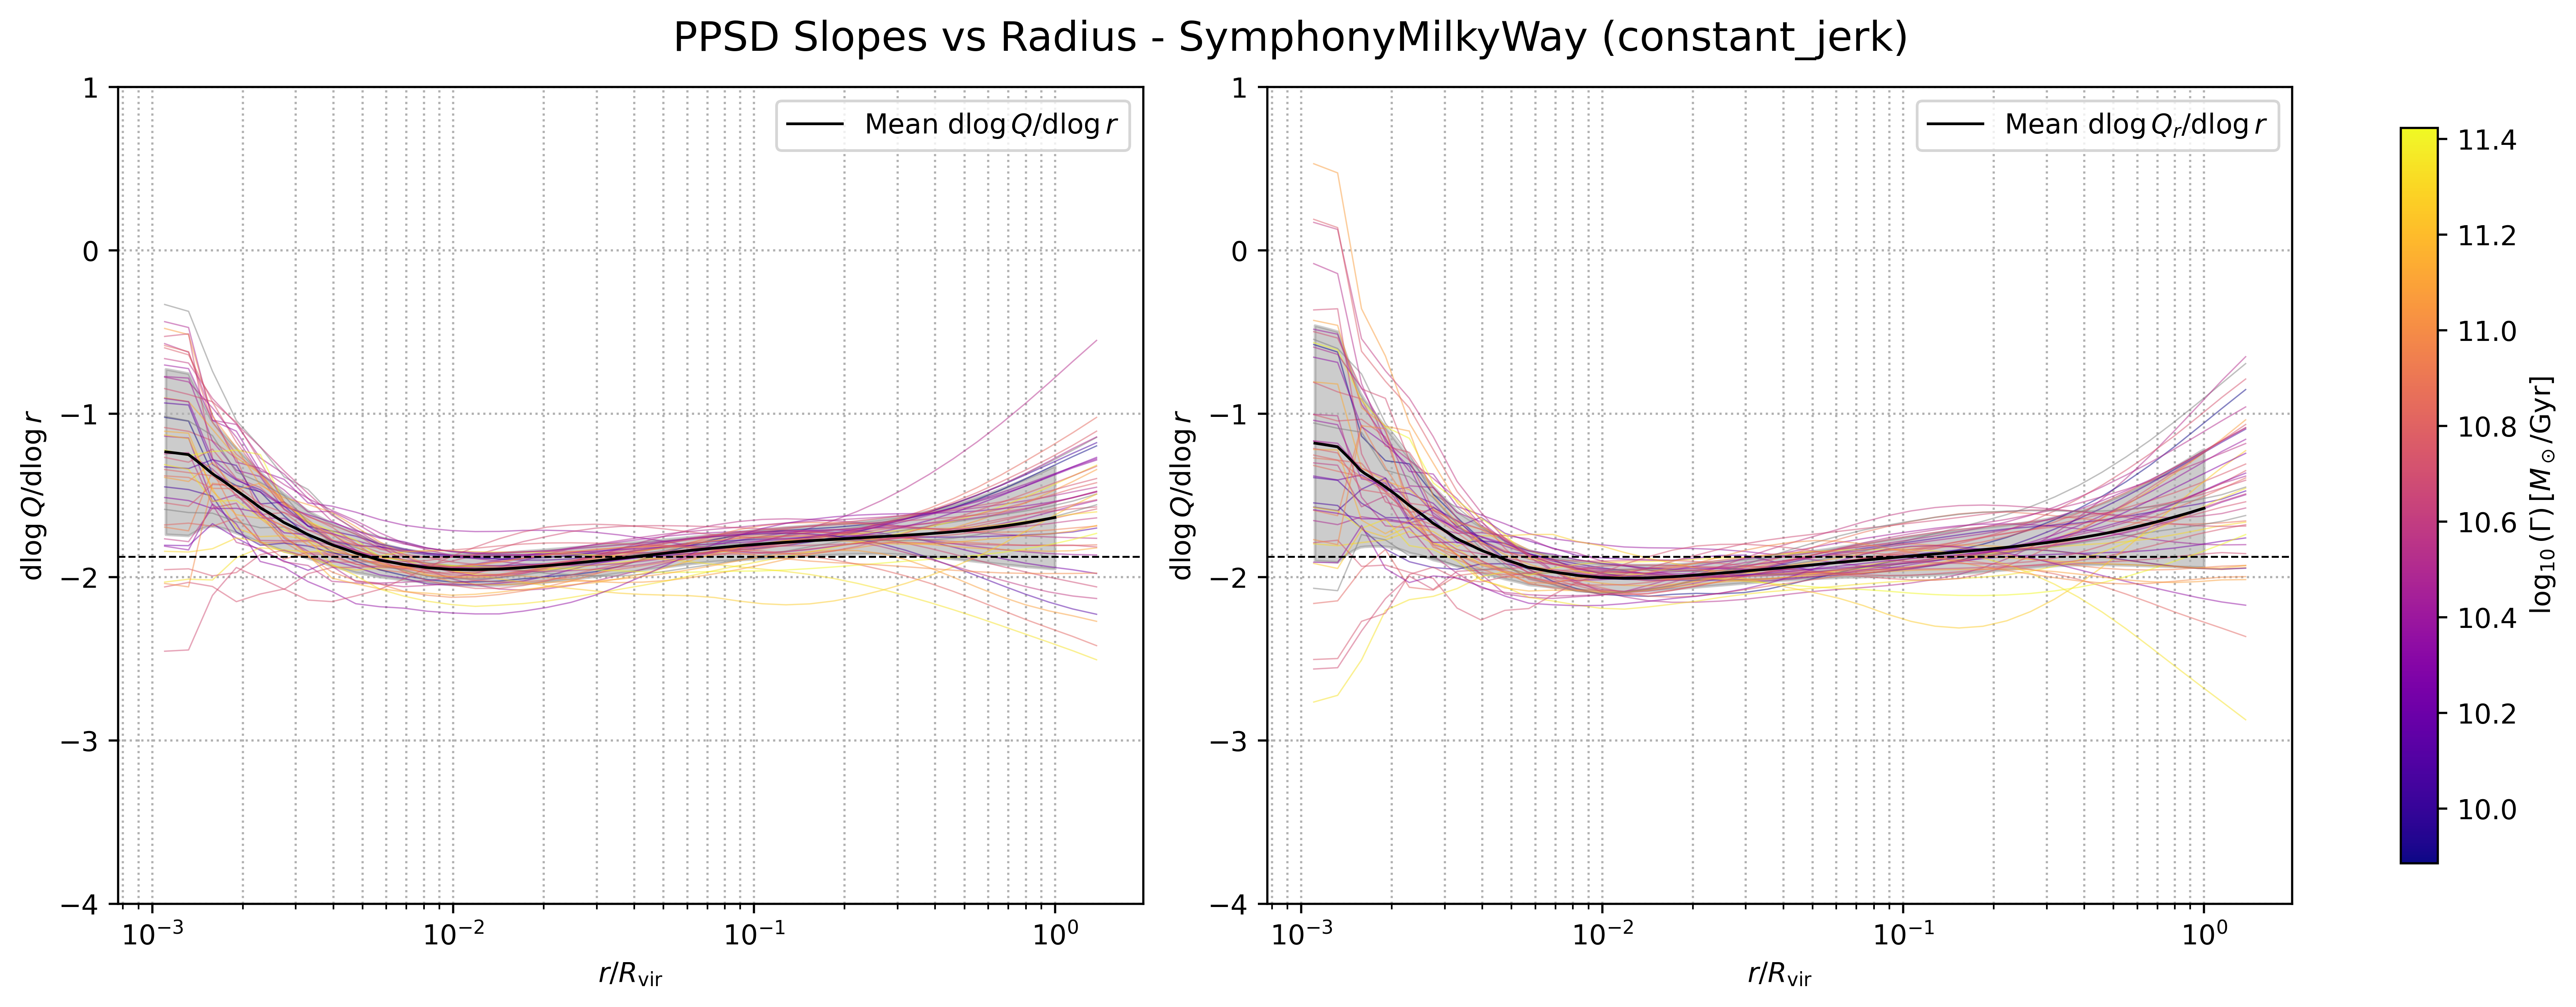

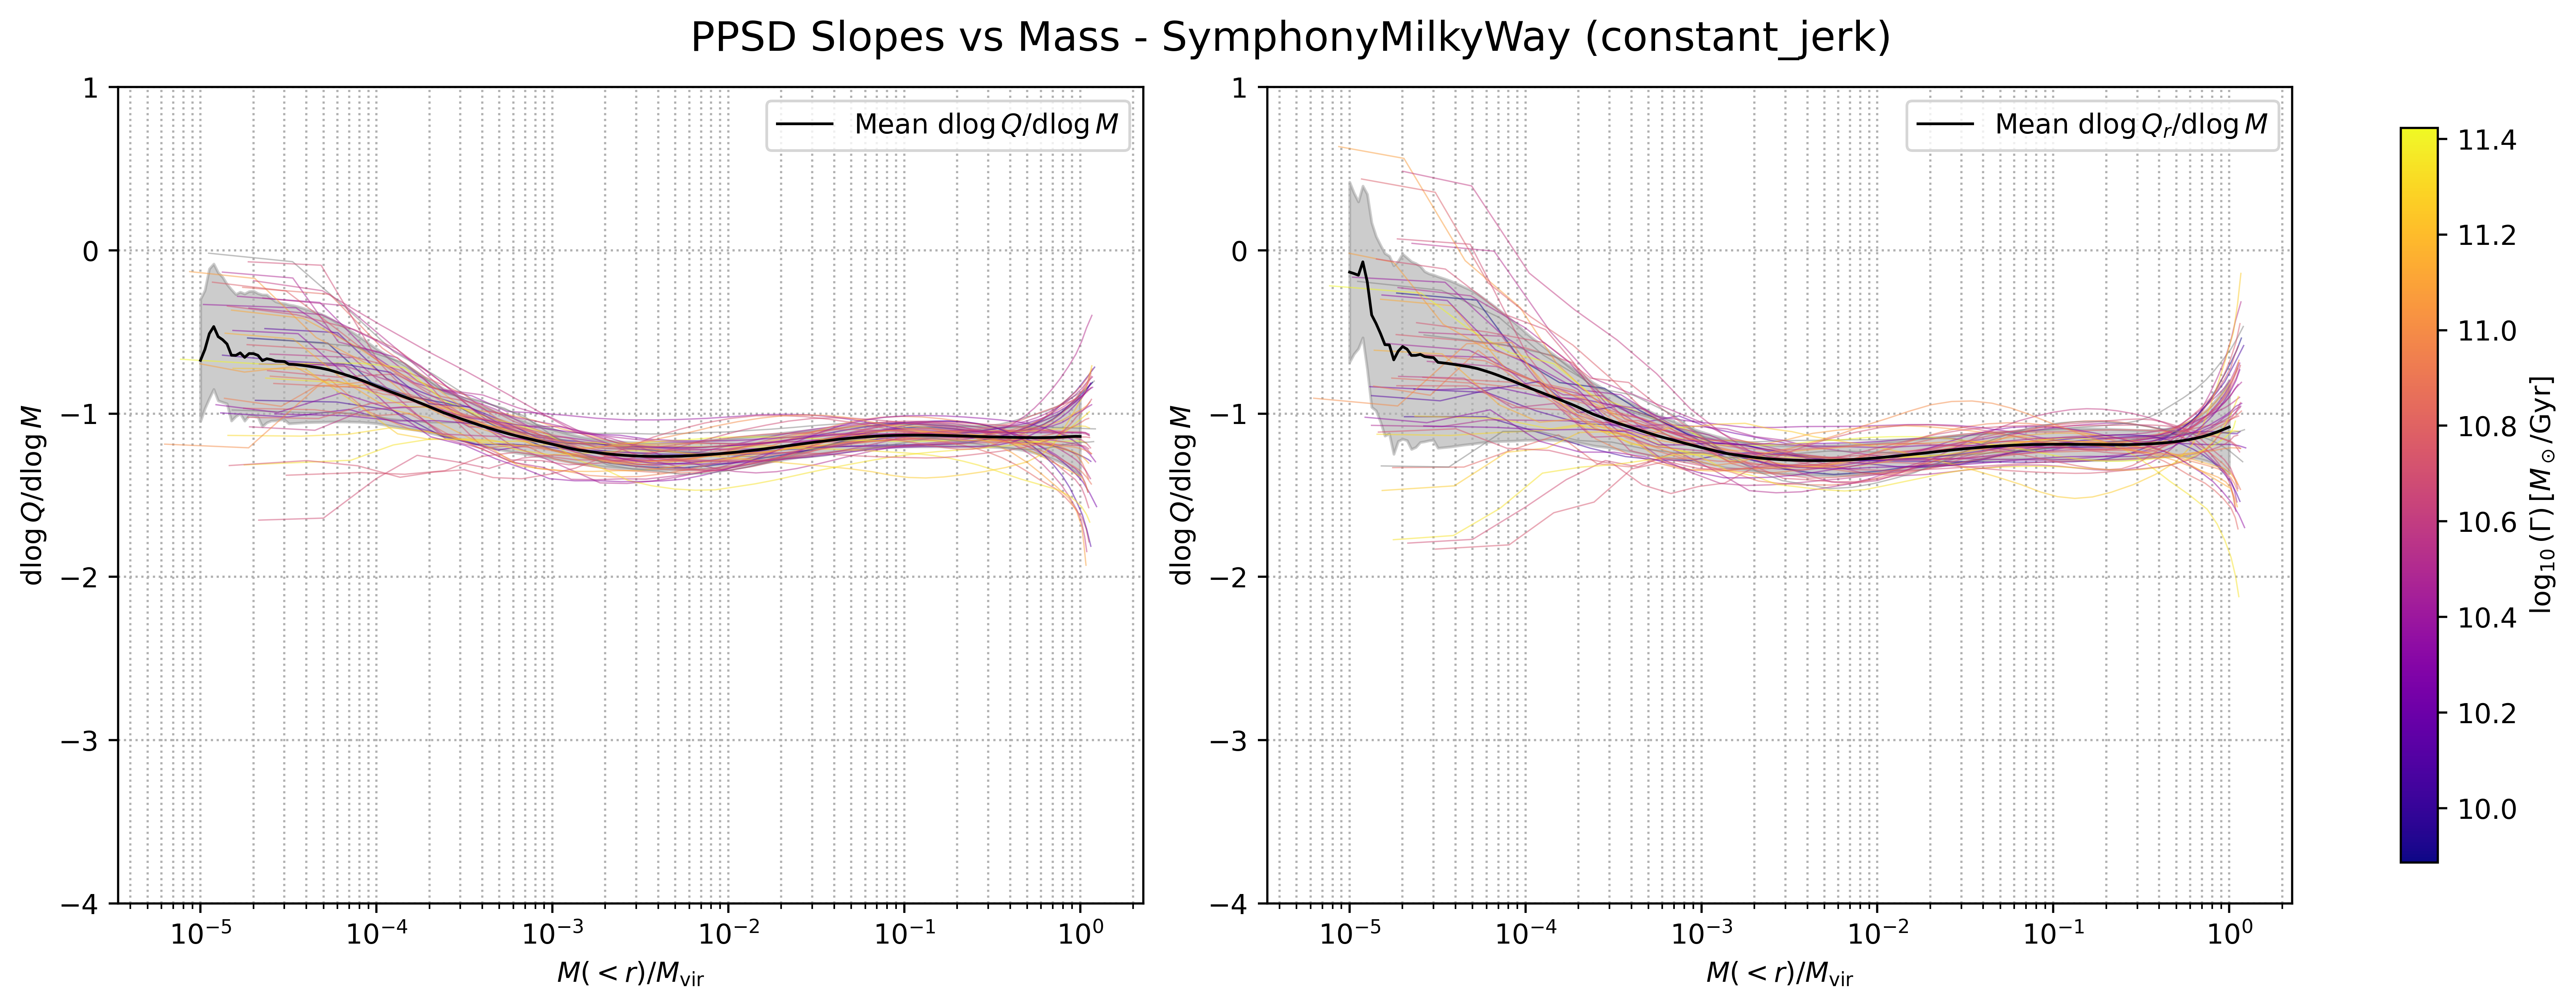

[Saved] slope-only figures colored by accretion rate (constant_jerk)


In [ ]:

def calculate_accretion_rate(sim_dir):
    try:
        scale = symlib.scale_factors(sim_dir)
        r, _ = symlib.read_rockstar(sim_dir)
        snap = len(scale) - 1  # z=0
        m_now = r[0, snap]["m"]

        sim_params = symlib.simulation_parameters(sim_dir)
        cosmo = cosmology.setCosmology("custom", {
            "flat": sim_params["flat"],
            "H0": sim_params["H0"],
            "Om0": sim_params["Om0"],
            "Ob0": sim_params["Ob0"],
            "sigma8": sim_params["sigma8"],
            "ns": sim_params["ns"]
        })

        rho_m0 = cosmo.rho_m(0)
        Delta = 99
        rho_vir = Delta * rho_m0 * 1e9 / sim_params["h100"]**2  # M_sun / Mpc^3
        G_val = G.to(u.Mpc**3 / (u.Msun * u.Gyr**2)).value
        t_dyn = 1.0 / np.sqrt((4/3) * np.pi * G_val * rho_vir)

        times = cosmo.age(1 / scale - 1)
        t0 = times[snap]
        t_past = t0 - t_dyn
        snap_past = np.argmin(np.abs(times - t_past))
        m_past = r[0, snap_past]["m"]

        gamma = (m_now - m_past) / t_dyn
        return gamma

    except Exception as e:
        warnings.warn(f"[AccretionRate] {e}")
        return np.nan
    
def ppsd_slope_colored_by_accretion_rate(base_dir, suite_name, method='constant_jerk', tvgamma=None):

    # --- Get accretion rates ---
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    n_halos = len(density_files)

    accretion_rates = []
    for i in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, i)
        try:
            scale = symlib.scale_factors(sim_dir)
            r, _ = symlib.read_rockstar(sim_dir)
            snap = len(scale) - 1
            m_now = r[0, snap]["m"]
            sim_params = symlib.simulation_parameters(sim_dir)
            cosmo = cosmology.setCosmology("custom", {
                "flat": sim_params["flat"], "H0": sim_params["H0"],
                "Om0": sim_params["Om0"], "Ob0": sim_params["Ob0"],
                "sigma8": sim_params["sigma8"], "ns": sim_params["ns"]
            })
            rho_m0 = cosmo.rho_m(0)
            Delta = 99
            rho_vir = Delta * rho_m0 * 1e9 / sim_params["h100"]**2
            G_val = G.to(u.Mpc**3 / (u.Msun * u.Gyr**2)).value
            t_dyn = 1.0 / np.sqrt((4/3) * np.pi * G_val * rho_vir)
            times = cosmo.age(1 / scale - 1)
            t0 = times[snap]
            snap_past = np.argmin(np.abs(times - (t0 - t_dyn)))
            m_past = r[0, snap_past]["m"]
            gamma = (m_now - m_past) / t_dyn
        except Exception as e:
            warnings.warn(f"Accretion rate failed for halo {i}: {e}")
            gamma = np.nan
        accretion_rates.append(gamma)
    accretion_rates = np.array(accretion_rates)
    log_gamma = np.log10(np.where((accretion_rates > 0) & np.isfinite(accretion_rates), accretion_rates, np.nan))

    # --- Plot setup (slopes only) ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    fig2, axes2 = plt.subplots(1, 2, figsize=(13, 5), dpi=500, constrained_layout=True)
    ax_slope_tot, ax_slope_rad = axes1
    ax_slope_tot_m, ax_slope_rad_m = axes2

    cmap = cm.plasma
    norm = colors.Normalize(vmin=np.nanmin(log_gamma), vmax=np.nanmax(log_gamma))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    slopes_r_tot, slopes_r_rad = [], []
    slopes_m_tot, slopes_m_rad = [], []

    def fit_and_plot(logx, logQ, ax, storage, color):
        dt = (logx[1:] - logx[:-1]).mean()
        if np.sum(np.isfinite(logx) & np.isfinite(logQ)) < 6: return
        x_valid = logx[np.isfinite(logx) & np.isfinite(logQ)]
        y_valid = logQ[np.isfinite(logx) & np.isfinite(logQ)]
        try:
            for submod in ['linear_model', 'finite_difference', 'smooth_finite_difference', 'total_variation_regularization', 'kalman_smooth']:
                try:
                    optimize_func = getattr(getattr(pynumdiff.optimize, submod), method)
                    diff_func = getattr(getattr(pynumdiff, submod), method)
                    break
                except AttributeError:
                    continue
            kwargs = {'tvgamma': tvgamma} if 'tvgamma' in optimize_func.__code__.co_varnames else {}
            params, _ = optimize_func(y_valid, dt, **kwargs)
            _, dydx = diff_func(y_valid, dt, params)
            x_val = 10**x_valid
            ax.plot(x_val, dydx, color=color, alpha=0.5, lw=0.5)
            storage.append((x_val, dydx))
        except Exception as e:
            warnings.warn(f"{method} failed: {e}")

    for i in range(n_halos):
        df_rho = pd.read_csv(os.path.join(density_dir, density_files[i]))
        df_vel = pd.read_csv(os.path.join(velocity_dir, velocity_files[i]))
        df_mass = pd.read_csv(os.path.join(mass_dir, mass_files[i]))

        r = df_rho["r_scaled"].values
        m = df_mass["m_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q_tot = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)
            Q_rad = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)

        log_r = np.log10(r)
        log_m = np.log10(m)
        log_Q_tot = np.log10(Q_tot)
        log_Q_rad = np.log10(Q_rad)

        color = cmap(norm(log_gamma[i])) if np.isfinite(log_gamma[i]) else "gray"
        fit_and_plot(log_r, log_Q_tot, ax_slope_tot, slopes_r_tot, color)
        fit_and_plot(log_r, log_Q_rad, ax_slope_rad, slopes_r_rad, color)
        fit_and_plot(log_m, log_Q_tot, ax_slope_tot_m, slopes_m_tot, color)
        fit_and_plot(log_m, log_Q_rad, ax_slope_rad_m, slopes_m_rad, color)

    def plot_mean_shaded(ax, curves, label, x_range=(1e-3, 1)):
        x_common = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 200)
        interp = [np.interp(x_common, x, y, left=np.nan, right=np.nan)
                for x, y in curves if np.all(np.isfinite(x)) and np.all(np.isfinite(y))]
        if not interp: return
        arr = np.array(interp)
        mean = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        ax.plot(x_common, mean, 'k-', lw=1, label=label)
        ax.fill_between(x_common, mean - std, mean + std, color='gray', alpha=0.4)
        ax.legend()

    plot_mean_shaded(ax_slope_tot, slopes_r_tot, r"Mean $\mathrm{d}\log Q/\mathrm{d}\log r$", x_range=(1e-3, 1))
    plot_mean_shaded(ax_slope_rad, slopes_r_rad, r"Mean $\mathrm{d}\log Q_r/\mathrm{d}\log r$", x_range=(1e-3, 1))

    plot_mean_shaded(ax_slope_tot_m, slopes_m_tot, r"Mean $\mathrm{d}\log Q/\mathrm{d}\log M$", x_range=(1e-5, 1))
    plot_mean_shaded(ax_slope_rad_m, slopes_m_rad, r"Mean $\mathrm{d}\log Q_r/\mathrm{d}\log M$", x_range=(1e-5, 1))

    # --- Format ---
    for ax in [ax_slope_tot, ax_slope_rad]:
        ax.set_xlabel(r"$r / R_{\mathrm{vir}}$")
        ax.set_ylabel(r"$\mathrm{d}\log Q / \mathrm{d}\log r$")
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.axhline(-1.875, color='k', ls='--', lw=0.7)
        ax.grid(True, which="both", linestyle=":")

    for ax in [ax_slope_tot_m, ax_slope_rad_m]:
        ax.set_xlabel(r"$M(<r) / M_{\mathrm{vir}}$")
        ax.set_ylabel(r"$\mathrm{d}\log Q / \mathrm{d}\log M$")
        ax.set_xscale("log")
        ax.set_ylim(-4, 1)
        ax.grid(True, which="both", linestyle=":")

    # --- Save ---
    fig1.suptitle(f"PPSD Slopes vs Radius - {suite_name} ({method})", fontsize=15)
    fig1.colorbar(sm, ax=axes1.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)\, [M_\odot / \mathrm{Gyr}]$")
    fig1.savefig(os.path.join(output_dir, f"PPSD_slopes_r_only_gamma_{method}.png"))

    fig2.suptitle(f"PPSD Slopes vs Mass - {suite_name} ({method})", fontsize=15)
    fig2.colorbar(sm, ax=axes2.ravel().tolist(), shrink=0.9).set_label(r"$\log_{10}(\Gamma)\, [M_\odot / \mathrm{Gyr}]$")
    fig2.savefig(os.path.join(output_dir, f"PPSD_slopes_m_only_gamma_{method}.png"))

    plt.show()
    plt.close(fig1)
    plt.close(fig2)

    print(f"[Saved] slope-only figures colored by accretion rate ({method})")

ppsd_slope_colored_by_accretion_rate(
    "/Volumes/Atlas/Symphony",
    "SymphonyMilkyWay",
    method="constant_jerk",
    tvgamma=None
)